In [35]:
import random
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
import pandas as pd
import math

In [89]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [2]:
def readNPDBFiles(path, n):
    file = open(path, "r")
    lines = file.readlines()
    pdbs = [(line.strip()[:4], line.strip()[4:5]) for line in lines[1:]]
    random.shuffle(pdbs)
    return pdbs[0:n]

In [66]:
def getPDBFile(pdb):
        try:
            url = "https://files.rcsb.org/view/{}.pdb".format(pdb)
            response = urllib.request.urlopen(url)
            data = response.read()
            text = data.decode('utf-8')
            text = text.split('\n')
            return(text)
        except:
            return([])

In [90]:
def getAtomCoordinates(lines, chain, aaNum, atom):
    atomLines = [line for line in lines if line.startswith("ATOM")]
    for line in atomLines:
        name = line[12:16].strip()
        chainID = line[21].strip()
        resSeq = line[22:26].strip()
        x = line[30:38].strip()
        y = line[38:46].strip()
        z = line[46:54].strip()
        if chainID == chain and resSeq == aaNum and atom == name:
            return(x, y, z)
    return None

def getTorsion(p1, p2, p3, p4):
    q1 = np.subtract(p2, p1)
    q2 = np.subtract(p3, p2)
    q3 = np.subtract(p4, p3)
    
    q1_x_q2 = np.cross(q1, q2)
    q2_x_q3 = np.cross(q2, q3)
    
    n1 = q1_x_q2/np.sqrt(np.dot(q1_x_q2,q1_x_q2))
    n2 = q2_x_q3/np.sqrt(np.dot(q2_x_q3,q2_x_q3))
    
    u1 = n2
    u3 = q2/(np.sqrt(np.dot(q2,q2)))
    u2 = np.cross(u3,u1)
    
    cos_theta = np.dot(n1,u1)
    sin_theta = np.dot(n1,u2)
    
    theta = -math.atan2(sin_theta,cos_theta)
    theta_deg = np.degrees(theta)
    
    return(theta_deg)

def getPhi(lines, chain, aaNum):
    if aaNum == 1:
        return None
    
    # C of aaNum-1
    atom1Coords = getAtomCoordinates(lines, chain, str(int(aaNum)-1), "C")
    atom1Coords = np.array(atom1Coords).astype(float)
    
    # N of aaNum
    atom2Coords = getAtomCoordinates(lines, chain, aaNum, "N")
    atom2Coords = np.array(atom2Coords).astype(float)
    
    # CA of aaNum
    atom3Coords = getAtomCoordinates(lines, chain, aaNum, "CA")
    atom3Coords = np.array(atom3Coords).astype(float)
    
    # C of aaNum
    atom4Coords = getAtomCoordinates(lines, chain, str(int(aaNum)), "C")
    atom4Coords = np.array(atom4Coords).astype(float)
    
    return getTorsion(atom1Coords, atom2Coords, atom3Coords, atom4Coords)

def getPsi(lines, chain, aaNum):
    if aaNum == 1:
        return None
    
    # CA of aaNum-1
    atom1Coords = getAtomCoordinates(lines, chain, aaNum, "N")
    atom1Coords = np.array(atom1Coords).astype(float)
    
    # C of aaNum-1
    atom2Coords = getAtomCoordinates(lines, chain, aaNum, "CA")
    atom2Coords = np.array(atom2Coords).astype(float)
    
    # N of aaNum
    atom3Coords = getAtomCoordinates(lines, chain, aaNum, "C")
    atom3Coords = np.array(atom3Coords).astype(float)
    
    # CA of aaNum
    atom4Coords = getAtomCoordinates(lines, chain, str(int(aaNum)+1), "N")
    if(atom4Coords == None):
        return np.nan
    atom4Coords = np.array(atom4Coords).astype(float)
    
    return getTorsion(atom1Coords, atom2Coords, atom3Coords, atom4Coords)

def getAngle(chain, aaNum, torsion):
    if(torsion == "phi"):
        return getPhi(chain, aaNum)
    if(torsion == "psi"):
        return getPsi(chain, aaNum)
    return("error")

In [92]:
def AnalyzePDB_Q6(pdbs):
    processed = 1
    phi_list = []
    psi_list = []
    for pdb in pdbs:
        update_progress(processed / len(pdbs))
        #print("Processing {}/{}".format(processed, len(pdbs)))
        lines = getPDBFile(pdb[0])
        aaNums = set()
        atoms = [line for line in lines if line.startswith("ATOM")]
        prevaaNum = -1
        for atom in atoms:
            chainID = atom[21].strip()
            aaNum = atom[22:26].strip()
            residueName = atom[17:20].strip()
            if(chainID == pdb[1] and prevaaNum != aaNum):
                if(residueName == "ALA"):
                    #Process
                    phi = getPhi(lines, chainID, aaNum)
                    psi = getPsi(lines, chainID, aaNum)
                    if(math.isnan(phi) or math.isnan(psi)):
                        prevaaNum = aaNum
                        continue
                    phi_list.append(phi)
                    psi_list.append(psi)
            prevaaNum = aaNum
        processed+=1
    return(phi_list, psi_list)

In [ ]:
pdbs = readNPDBFiles("cullpdb_pc30_res3.0_R1.0_d191017_chains18877", 1000)
phi, psi = AnalyzePDB_Q6(pdbs)


Progress: [--------------------] 2.3%
Nan Encountered Continue nan -24.423723220827835


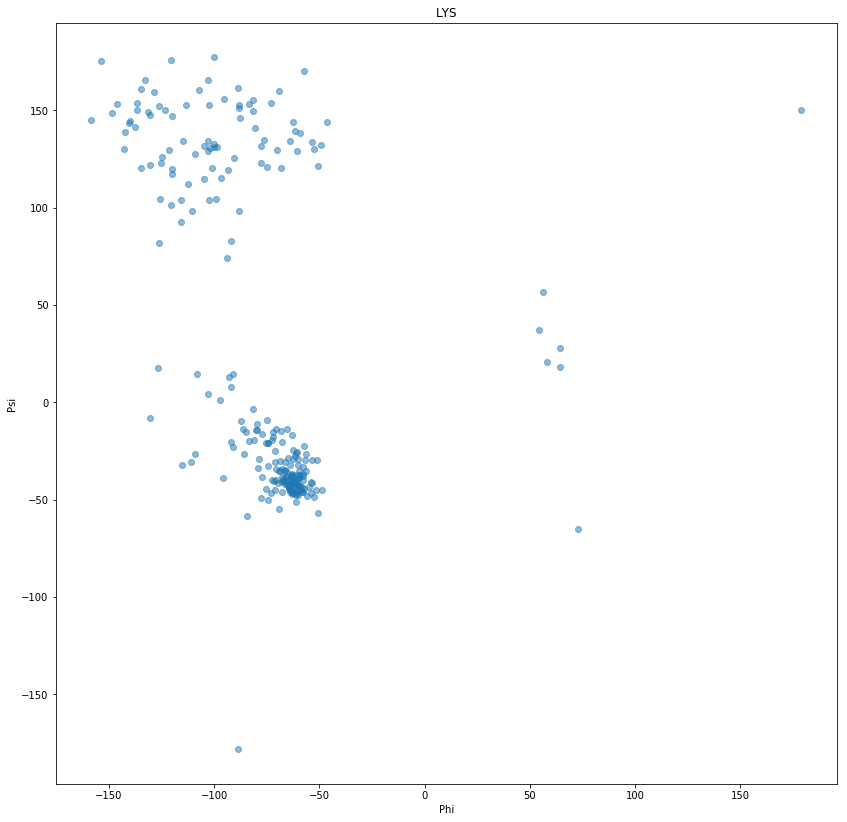

In [83]:
# Plot
fig, ax = plt.subplots()
ax = plt.scatter(phi, psi, alpha=0.5)
fig.set_size_inches(14, 14)
plt.title('LYS')
plt.xlabel('Phi')
plt.ylabel('Psi')
plt.show()